<a href="https://colab.research.google.com/github/aidasharif1365/Machine-Learning/blob/main/PS1_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this experiment, you will train models to distringuish examples of two different genres of Shakespeare's plays: comedies and tragedies. (We'll ignore the histories, sonnets, etc.) Since he died four hundred years ago, Shakespeare has not written any more plays—although scraps of various other works have come to light. We are not, therefore, interested in building models simply to help categorize an unbounded stream of future documents, as we might be in other applications of text classification; rather, we are interested in what a classifier might have to tell us about what we mean by the terms “comedy” and “tragedy”.

You will start by copying and running your `createBasicFeatures` function from the experiment with movie reviews. Do the features the classifier focuses on tell you much about comedy and tragedy in general?

You will then implement another featurization function `createInterestingFeatures`, which will focus on only those features you think are informative for distinguishing between comedy and tragedy. Accuracy on leave-one-out cross-validation may go up, but it more important to look at the features given the highest weight by the classifier. Interpretability in machine learning, of course, may be harder to define than accuracy—although accuracy at some tasks such as summarization is hard enoough.

In [ ]:
import re
import nltk
import json
import spacy
import string
import requests
import collections
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,LeaveOneOut,KFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from spacy.lang.en import English
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#read in the shakespeare corpus
def readShakespeare():
  raw = requests.get("https://raw.githubusercontent.com/mutherr/CS6120-PS1-data/master/shakespeare_plays.json").text.strip()
  corpus = [json.loads(line) for line in raw.split("\n")]

  #remove histories from the data, as we're only working with tragedies and comedies
  corpus = [entry for entry in corpus if entry["genre"] != "history"]
  return corpus

In [ ]:
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [ ]:
def lemmaSentence(sentence):
  wordnet_lemmatizer = WordNetLemmatizer()
  token_words=word_tokenize(sentence)
  lemma_sentence=[]
  for word in token_words:
      lemma_sentence.append(wordnet_lemmatizer.lemmatize(word))
      lemma_sentence.append(" ")
  return "".join(lemma_sentence)

In [ ]:
def remove_stopwords(sentence,stopwords_dict):
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  #punctuations=''
  no_punct = ""
  token_words=word_tokenize(sentence)
  no_stop=' '.join([word for word in token_words if word not in stopwords_dict])

  for char in no_stop:
    if char not in punctuations:
        no_punct = no_punct + char
  return no_punct

This is where you will implement two functions to featurize the data:

In [ ]:
#NB: The current contents are for testing only
#This function should return: 
#  -a sparse numpy matrix of document features
#  -a list of the correct genre for each document
#  -a list of the vocabulary used by the features, such that the ith term of the
#    list is the word whose counts appear in the ith column of the matrix. 

# This function should create a feature representation using all tokens that
# contain an alphabetic character.
def createBasicFeatures(corpus):
  texts=[]
  vocab=[]
  classes=[]

  for i in range(len(corpus)):
    texts.append(corpus[i]["text"])
    classes.append(corpus[i]["genre"])
    
  #using countvectorizer to count words in documents
  one_hot_vectorizer = CountVectorizer()
  one_hot_matrix = one_hot_vectorizer.fit_transform(texts)
  vocab_dict = (one_hot_vectorizer.vocabulary_)

  for k in vocab_dict:
    vocab.append(k)

  return one_hot_matrix,classes,vocab

In [ ]:
corpus = readShakespeare()
X,y,vocab = createBasicFeatures(corpus)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.769231
The most informative terms for pos are: ['pounds', 'gums', 'minimus', 'elevated', 'rogero', 'mountebanks', 'rests', 'immoment', 'unspoke', 'wrist', 'couplement', 'guerra', 'fortuna', 'whereuntil', 'parfect', 'arinado', 'pursents', 'vara', 'career', 'jesting']
The most informative terms for neg are: ['beaks', 'cautelous', 'lading', 'brood', 'bemete', 'stubble', 'corse', 'vox', 'deserves', 'glowing', 'ber', 'simile', 'arinado', 'couplement', 'guerra', 'whereuntil', 'pompion', 'parfect', 'pursents', 'vara']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['rogero', 'gums', 'immoment', 'pounds', 'braving', 'rests', 'mountebanks', 'elevated', 'minimus', 'new', 'disarm', 'accompanied', 'goosequills', 'repeals', 'partially', 'despiseth', 'clad', 'hears', 'alexander', 'wrist']
The most informative terms for neg are: ['stubble', 'brood', 'cautelous', 'beaks', 'ston

In [ ]:
#checkinng the most used words in pos and neg classes to make the stopword list
pos_dict=collections.defaultdict(lambda:0)
neg_dict=collections.defaultdict(lambda:0)

for i in range(len(corpus)):
  sentence=(corpus[i]["text"])
  token_words=word_tokenize(sentence)
  if corpus[i]["genre"]=='comedy':
    for word in token_words:
      pos_dict[word]=pos_dict[word]+1
  elif corpus[i]["genre"]=='tragedy': 
    for word in token_words:
      neg_dict[word]=neg_dict[word]+1
        
      
pos_dict={k:v for k,v in sorted(pos_dict.items(), key=lambda item:item[1],reverse=True)}
neg_dict={k:v for k,v in sorted(neg_dict.items(), key=lambda item:item[1],reverse=True)}


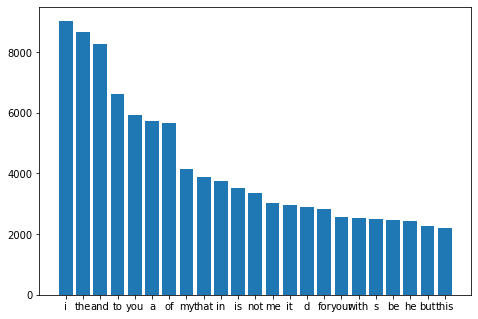

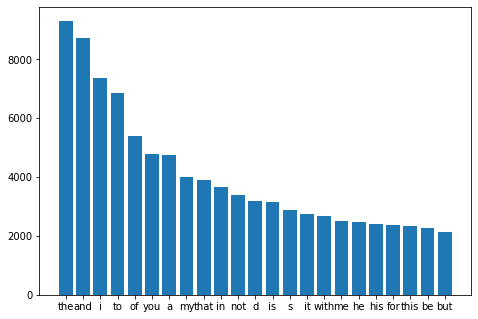

In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.figure()
fig2 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax2 = fig2.add_axes([0,0,1,1])
freqPos = []
wordsPos = []
freqNeg = []
wordsNeg = []

limit=23
for k in neg_dict:
  if limit>0:
    wordsNeg.append(k)
    freqNeg.append(neg_dict[k])
  limit-=1

limit=23
for k in pos_dict:
  if limit>0:
    wordsPos.append(k)
    freqPos.append(pos_dict[k])
  limit-=1

ax2.bar(wordsNeg,freqNeg)
ax1.bar(wordsPos,freqPos)
plt.show()

In [ ]:
words=['the', 'and','i','of','my','is','a','he','his','for','d','with']
stopwords_dict=dict.fromkeys(words,1)

In [ ]:
# This function can add other features you want that help classification
# accuracy, such as bigrams, word prefixes and suffixes, etc.
#it stems, lemmatizes, removes stopwords, sets thresholds of min and max number
#of words in Countervectorizer, uses ngrams
#each feature changer could be turned on or off
def createInterestingFeatures(corpus,stopword,stem,lemma,ngram,mindf,maxdf):
  raw=[]
  vocab=[]
  classes=[]

  #based on the feature changer options this loops implements different parts
  for i in range(len(corpus)):
    sentence=(corpus[i]["text"])
    if stopword:
      sentence=remove_stopwords(sentence,stopwords_dict)
    if stem:
      sentence=stemSentence(sentence)
    if lemma: 
      sentence=lemmaSentence(sentence)
    raw.append(sentence)
    classes.append(corpus[i]["genre"])

  #setting ngrams, min_df and max_df in Countervectorizer
  vectorizer = CountVectorizer(ngram_range=ngram,min_df=mindf,max_df=maxdf) 
  #fitting the vectorizer
  ngram_matrix = vectorizer.fit_transform(raw)
  vocab_dict = (vectorizer.vocabulary_)

  for k in vocab_dict:
    vocab.append(k)

  return ngram_matrix,classes,vocab


Best result:

In [ ]:
words=['the', 'and','i','of','my','is','a','he','his','for','d','with']
stopwords_dict=dict.fromkeys(words,1)
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=False,lemma=False,ngram=(0,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.884615
The most informative terms for pos are: ['think for', 'between this', 'me hear', 'do love my', 'not here', 'needful', 'with us to', 'his mind', 'exit duke', 'you do remember', 'the heart to', 'and through the', 'you my good', 'all and leave', 'you have little', 'them to you', 'you think you', 'are at the', 'you have you', 'you where he']
The most informative terms for neg are: ['pompey pompey', 'were such', 'me with patience', 'will by', '', 'on the way', 'an please you', 'when all the', 'which ne er', 'you have little', 'you do remember', 'the heart to', 'you my good', 'of all and', 'all and leave', 'them to you', 'you think you', 'are at the', 'you have you', 'you where he']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['think for', 'me hear', 'needful', 'do love my', 'with us to', 'between this', 'exit duke', 'not here', 'behold my', 'his mind', 'lad

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=True,lemma=True,ngram=(0,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.846154
The most informative terms for pos are: ['horn in', 'befor thee', 'wa to', 'he had no', 'fear thi', 'time good', 'is now the', 'should pay', 'fool fool', 'they say there', 'thousand of these', 'beseech you what', 'to break the', 'them on the', 'am glad on', 'true that you', 'to sin in', 'thou shalt see', 'me onc more', 'your compani to']
The most informative terms for neg are: ['with much', 'were such', 'hath not yet', 'thi state', '', 'with bloodi', 'keep you in', 'they say they', 'stand not in', 'they say there', 'thousand of these', 'love than', 'beseech you what', 'of the citi', 'to break the', 'am glad on', 'true that you', 'to sin in', 'thou shalt see', 'me onc more']
----------L2 Norm-----------
The model's average accuracy is 0.692308
The most informative terms for pos are: ['horn in', 'wa to', 'time good', 'he had no', 'befor thee', 'is now the', 'fool fool', 'fear thi', 'fan and', 'should pay', 'thou dost a

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=True,stem=True,lemma=True,ngram=(1,3),mindf=2,maxdf=2000)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.807692
The most informative terms for pos are: ['lord can', 'yet some', 'her knee', 'guess at', 'wors for me', 'thousand death would', 'craft', 'sweep', 'do our', 'womanish', 'menac', 'climat', 'prodigi', 'knotti', 'ghastli', 'stoni', 'unfirm', 'howev', 'tomorrow', 'shriek']
The most informative terms for neg are: ['for lord', 'll sauc', 'rome antoni', 'in king', 'but we are', 'had but one', 'for most part', 'like hi', 'to fli', 'to market', 'knotti', 'ghastli', 'unfirm', 'retent', 'prodigi', 'howev', 'climat', 'menac', 'womanish', 'stoni']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['wors for me', 'do our', 'her knee', 'lord can', 'craft', 'guess at', 'yet some', 'sweep', 'further into', 'thousand death would', 'like poison', 'gentleman to', 'princ that', 'thi stori', 'arraign', 'though he', 'late have', 'second gentleman ti', 'scar', 'duti which']
The most

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=True,stem=True,lemma=True,ngram=(1,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.884615
The most informative terms for pos are: ['whom thou', 'to be command', 'speech will', 'sovereignti', 'myself will', 'you swear', 'cur in', 'lord exeunt', 'here therefor', 'suit that', 'them while', 'thi we', 'in either', 'all', 'all hail', 'peac thou', 'such name', 'dogg with', 'either side', 'honour no']
The most informative terms for neg are: ['face but', 'true he', 'if he love', 'love day', 'almost come', 'no marvel', 'hand who', 'have sat', 'thu if', 'therebi to', 'honour no', 'all', 'thi we', 'in either', 'either side', 'all hail', 'peac thou', 'such name', 'suit that', 'them while']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['myself will', 'whom thou', 'here therefor', 'sovereignti', 'to be command', 'you swear', 'speech will', 'lord exeunt', 'cur in', 'run by', 'make an', 'give way to', 'have kept', 'yet though', 'boy hath', 'find thi', 'impre

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=True,stem=True,lemma=True,ngram=(1,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.846154
The most informative terms for pos are: ['whom thou', 'speech will', 'to be command', 'sovereignti', 'myself will', 'cur in', 'you swear', 'lord exeunt', 'here therefor', 'suit that', 'them while', 'thi we', 'in either', 'all', 'all hail', 'peac thou', 'such name', 'dogg with', 'either side', 'honour no']
The most informative terms for neg are: ['face but', 'true he', 'if he love', 'love day', 'almost come', 'no marvel', 'hand who', 'have sat', 'thu if', 'therebi to', 'honour no', 'all', 'thi we', 'in either', 'either side', 'all hail', 'peac thou', 'such name', 'suit that', 'them while']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['myself will', 'whom thou', 'here therefor', 'sovereignti', 'to be command', 'you swear', 'speech will', 'lord exeunt', 'cur in', 'run by', 'make an', 'give way to', 'have kept', 'yet though', 'boy hath', 'find thi', 'impre

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=False,lemma=True,ngram=(0,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.807692
The most informative terms for pos are: ['sleep come', 'you wot', 'space for', 'ruin of the', 'grace is', 'patch', 'shall be so', 'not get', 'out my', 'he turn', 'life did', 'is thus', 'your loyal', 'servant or', 'endure your', 'bear from', 'am struck', 'with sorrow', 'this city', 'the injury']
The most informative terms for neg are: ['have mind', 'boy son', 'there an end', 'you set', '', 'all and leave', 'lord thou', 'done deed', 'not upon', 'put up', 'know in', 'which this', 'man life', 'noble master', 'life did', 'your loyal', 'loyal servant', 'servant or', 'endure your', 'bear from']
----------L2 Norm-----------
The model's average accuracy is 0.692308
The most informative terms for pos are: ['sleep come', 'space for', 'patch', 'ruin of the', 'shall be so', 'you wot', 'out my', 'grace is', 'say or', 'not get', 'up say', 'act iv', 'do assure', 'can not think', 'love be not', 'father so', 'stay here', 'would not wi

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=False,lemma=False,ngram=(1,2),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.846154
The most informative terms for pos are: ['leagues off', 'trouble the', 'cannot call', 'you back', 'you came', 'offence', 'scanted', 'they meet', 'you was', 'and heard', 'other will', 'am half', 'than fool', 'for truth', 'things should', 'do appear', 'should stand', 'why in', 'which first', 'crave the']
The most informative terms for neg are: ['he on', 'but teach', 'be fortunate', 'are and', 'should stand', 'do appear', 'things should', 'for truth', 'than fool', 'other will', 'why in', 'and heard', 'many things', 'some more', 'go without', 'am half', 'which first', 'well', 'him joy', 'voices and']
----------L2 Norm-----------
The model's average accuracy is 0.692308
The most informative terms for pos are: ['leagues off', 'cannot call', 'offence', 'you came', 'they meet', 'trouble the', 'than am', 'you back', 'am able', 'scanted', 'borne to', 'do nothing', 'towards him', 'and went', 'to thee', 'when thy', 'like dog', '

In [ ]:
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=False,lemma=False,ngram=(0,3),mindf=3,maxdf=2200)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.846154
The most informative terms for pos are: ['me hear', 'think for', 'between this', 'do love my', 'needful', 'not here', 'with us to', 'his mind', 'behold my', 'exit duke', 'you do remember', 'the heart to', 'and through the', 'you my good', 'them to you', 'all and leave', 'you think you', 'are at the', 'you have you', 'you where he']
The most informative terms for neg are: ['pompey pompey', 'were such', 'brought to', 'me with patience', 'will by', '', 'what haste', 'all and leave', 'you my good', 'and through the', 'the heart to', 'may as well', 'you do remember', 'you have little', 'them to you', 'which ne er', 'you think you', 'when all the', 'an please you', 'on the way']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['think for', 'me hear', 'needful', 'do love my', 'with us to', 'between this', 'exit duke', 'not here', 'behold my', 'his mind', 'lady sh

In [ ]:
words=['the', 'and','i','of','my','is','a','he','his','for','d','with']
stopwords_dict=dict.fromkeys(words,1)
X,y,vocab = createInterestingFeatures(corpus,stopword=False,stem=False,lemma=False,ngram=(0,3),mindf=3,maxdf=2400)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.884615
The most informative terms for pos are: ['think for', 'between this', 'me hear', 'do love my', 'not here', 'needful', 'with us to', 'his mind', 'exit duke', 'you do remember', 'the heart to', 'and through the', 'you my good', 'all and leave', 'you have little', 'them to you', 'you think you', 'are at the', 'you have you', 'you where he']
The most informative terms for neg are: ['pompey pompey', 'were such', 'me with patience', 'will by', '', 'on the way', 'an please you', 'when all the', 'which ne er', 'you have little', 'you do remember', 'the heart to', 'you my good', 'of all and', 'all and leave', 'them to you', 'you think you', 'are at the', 'you have you', 'you where he']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['think for', 'me hear', 'needful', 'do love my', 'with us to', 'between this', 'exit duke', 'not here', 'behold my', 'his mind', 'lad

In [ ]:
words=['the', 'and','i','of','my','is','a','he','his','for','d','with']
stopwords_dict=dict.fromkeys(words,1)
X,y,vocab = createInterestingFeatures(corpus,stopword=True,stem=True,lemma=True,ngram=(1,3),mindf=3,maxdf=2000)
runEvaluation(X, y, vocab)

----------L1 Norm-----------
The model's average accuracy is 0.846154
The most informative terms for pos are: ['when some', 'if they can', 'none but', 'attend enter', 'encount', 'soldier no', 'what danger', 'shall our', 'merci in', 'no hope', 'an engin', 'now than', 'differ between', 'respect not', 'time can', 'have got', 'short time', 'thi long', 'in charact', 'all']
The most informative terms for neg are: ['which seem', 'will shame', 'help in', 'me gentleman', 'send your', 'ere they', 'in charact', 'an engin', 'shall our', 'differ between', 'thi long', 'time can', 'short time', 'no hope', 'possibl you', 'respect not', 'merci in', 'now than', 'all', 'we on']
----------L2 Norm-----------
The model's average accuracy is 0.730769
The most informative terms for pos are: ['if they can', 'what danger', 'none but', 'attend enter', 'encount', 'soldier no', 'when some', 'am abl', 'night am', 'anoth way', 'shall see', 'it stain', 'have lov', 'left it', 'balanc', 'would that', 'thi glove', 'we a

In [ ]:
#given a numpy matrix representation of the features for the training set, the 
# vector of true classes for each example, and the vocabulary as described 
# above, this computes the accuracy of the model using leave one out cross 
# validation and reports the most indicative features for each class
def evaluateModel(X,y,vocab,penalty="l1"):
  #create and fit the model
  model = LogisticRegression(penalty=penalty,solver="liblinear")
  results = cross_validate(model,X,y,cv=LeaveOneOut())
  
  #determine the average accuracy
  scores = results["test_score"]
  avg_score = sum(scores)/len(scores)
  
  #determine the most informative features
  # this requires us to fit the model to everything, because we need a
  # single model to draw coefficients from, rather than 26
  model.fit(X,y)
  neg_class_prob_sorted = model.coef_[0, :].argsort()
  pos_class_prob_sorted = (-model.coef_[0, :]).argsort()

  termsToTake = 20
  pos_indicators = [vocab[i] for i in neg_class_prob_sorted[:termsToTake]]
  neg_indicators = [vocab[i] for i in pos_class_prob_sorted[:termsToTake]]

  return avg_score,pos_indicators,neg_indicators

def runEvaluation(X,y,vocab):
  print("----------L1 Norm-----------")
  avg_score,pos_indicators,neg_indicators = evaluateModel(X,y,vocab,"l1")
  print("The model's average accuracy is %f"%avg_score)
  print("The most informative terms for pos are: %s"%pos_indicators)
  print("The most informative terms for neg are: %s"%neg_indicators)
  #this call will fit a model with L2 normalization
  print("----------L2 Norm-----------")
  avg_score,pos_indicators,neg_indicators = evaluateModel(X,y,vocab,"l2")
  print("The model's average accuracy is %f"%avg_score)
  print("The most informative terms for pos are: %s"%pos_indicators)
  print("The most informative terms for neg are: %s"%neg_indicators)
  